# Armonk

Right now, I think our goal is to have better precision in our results. 
For instance, if we run experiments to calculate $R_0$, we expect the result to be as close as one as possible. 
To achieve my goal, I decided to use level measurement 1 and classify the results by myself.  But to do that, I need the position of the ground state and the excited state. That is why I am running the rabi experiment. 

In [398]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
from csv import writer
import sympy as sym 
import math
from functools import partial
from collections import Counter
from scipy.optimize import curve_fit

from my_functions_v1 import *   # My Functions

us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz


from qiskit import *
from qiskit import IBMQ 
from qiskit import pulse
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit import schedule
from qiskit import execute

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
#### from qiskit.visualization import * # Aparentemente tem que comentar essa linha aqui
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.jupyter import *
from qiskit.tools.visualization import plot_histogram

#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.pulse.library import Gaussian
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter, ParameterExpression  # This is Parameter Class for variable parameters.

from IPython.display import display, Math, Latex


import scipy.special  # https://stackoverflow.com/questions/36014733/official-abbreviation-for-import-scipy-as-sp-sc


# load account credentials
IBMQ.load_account() 

ibmqfactory.load_account:WARNING:2021-09-09 23:40:56,603: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [399]:
hub = 'ibm-q-research'
group = 'jerusalem-1'
project = 'main'

# hub='ibm-q'
# group='open'
# project='main'

backend_name =  'ibmq_armonk'  

# load provider
provider = IBMQ.get_provider(hub=hub, group=group, project=project)

# Get our backend
backend = provider.get_backend(backend_name)

# configuration - Hardware configuration information.
backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_props = backend.properties()

dt = backend_config.dt

# -------------------------------


assert backend_config.open_pulse , "Backend doesn't support Pulse!!!"
# print(backend_config.basis_gates)
# print(backend_config.hamiltonian['description'])  # Information about the Hamiltonian

display(Math(r'T_1(q_0)={} \ \mu\text{{s}}'.format(backend_props.t1(0)/us)))
display(Math(r'T_2(q_0)={} \ \mu\text{{s}}'.format(backend_props.t2(0)/us)))
display(Math(backend_config.hamiltonian['h_latex']))
display(Math(r'\omega_0={} \ \text{{GHz}}'.format(backend_config.hamiltonian["vars"]["wq0"]/GHz)))
display(Math(r'\Omega_0={} \ \text{{GHz}}'.format(backend_config.hamiltonian["vars"]["omegad0"]/GHz)))
display(Math(r'\Delta_0={} \ \text{{GHz}}'.format(backend_config.hamiltonian["vars"]["delta0"]/GHz)))
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds
time.ctime() 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Sampling time: 0.2222222222222222 ns


'Thu Sep  9 23:41:10 2021'

## Finding the qubit Frequency using a Frequency Sweep

In [234]:
qubit = 0
mem_slot = 0


# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release

print(f"\nQubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.\n")
time.ctime()     


Qubit 0 has an estimated frequency of 4.971604033654592 GHz.



'Thu Sep  9 17:54:10 2021'

In [233]:
# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 0.6 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)
print(f"\nThe sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.\n")
time.ctime()     


The sweep will go from 4.951604033654593 GHz to 4.991604033654593 GHz in steps of 0.6 MHz.



'Thu Sep  9 17:53:48 2021'

In [109]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)


drive_sigma_sec = 0.075 * us                            
drive_duration_sec = drive_sigma_sec * 8                
drive_amp = 0.05 

freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    #
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # 
    pulse.play(pulse.Gaussian(duration = drive_duration,
                              sigma = drive_sigma,
                              amp = drive_amp,
                              name = 'freq_sweep_excitation_pulse'), drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])
        

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedules = [sweep_sched.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

schedules[0].draw(backend=backend, style=IQXDebugging())

display(len(schedules)) # Armonk 75

67

In [110]:
num_shots_per_frequency = 8192

job_freq = backend.run(schedules, 
                  meas_level = 1, 
                  meas_return = 'avg', 
                  shots = num_shots_per_frequency)

print(job_freq.job_id())
job_monitor(job_freq)

time.ctime()     

613a302e88745f3442b9c0f6
Job Status: job has successfully run


'Thu Sep  9 13:19:12 2021'

In [113]:
frequency_sweep_results = job_freq.result(timeout=120) # timeout parameter set to 120 seconds

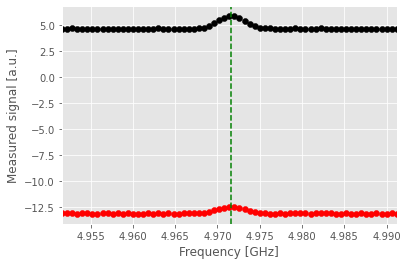

In [114]:
sweep_values = []

for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

    
plt.axvline(backend_defaults.qubit_freq_est[qubit] / GHz, color='green', linestyle='--')

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.scatter(frequencies_GHz, np.imag(sweep_values), color='red') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()


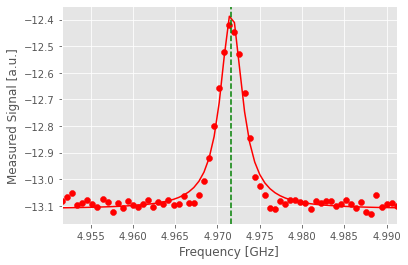


We've updated our qubit frequency estimate from 4.9716 GHz to 4.97163 GHz.



In [117]:
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit


fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.imag(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [4, center_frequency_Hz/GHz, 0.005, -12.5] # initial parameters for curve_fit
                                )
plt.scatter(frequencies_GHz, np.imag(sweep_values), color='red')


plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.axvline(backend_defaults.qubit_freq_est[qubit] / GHz, color='green', linestyle='--')

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()


A, rough_qubit_frequency_imag, B, C = fit_params

rough_qubit_frequency_imag = rough_qubit_frequency_imag*GHz # make sure qubit freq is in Hz

print(f"\nWe've updated our qubit frequency estimate from "
 f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency_imag/GHz, 5)} GHz.\n")

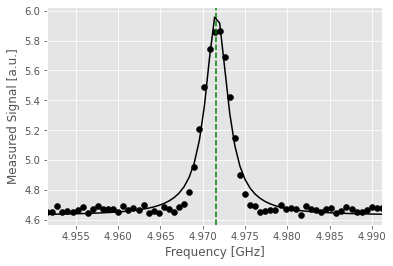


We've updated our qubit frequency estimate from 4.9716 GHz to 4.97164 GHz.



In [120]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [0.01, center_frequency_Hz/GHz, 0.001, 4.6] # initial parameters for curve_fit
                                )
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')

plt.axvline(backend_defaults.qubit_freq_est[qubit] / GHz, color='green', linestyle='--')


plt.plot(frequencies_GHz, y_fit, color='black')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

A, rough_qubit_frequency_real, B, C = fit_params

rough_qubit_frequency_real = rough_qubit_frequency_real*GHz # make sure qubit freq is in Hz

print(f"\nWe've updated our qubit frequency estimate from "
 f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency_real/GHz, 5)} GHz.\n")


In [126]:
rough_qubit_frequency = (rough_qubit_frequency_real + rough_qubit_frequency_imag)/2
rough_qubit_frequency_delta = np.abs(rough_qubit_frequency_real - rough_qubit_frequency_imag)/2

print(f"We've updated our qubit frequency estimate from "
 f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} \
  +/- {round(rough_qubit_frequency_delta/GHz,6)} GHz.")


We've updated our qubit frequency estimate from 4.9716 GHz to 4.97164   +/- 3e-06 GHz.


In [129]:
num_rabi_points = 70

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75

drive_amp_min = 0.0
drive_amp_max = 0.75 # 0.150255798881111  #0.5
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)


# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    #
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    #
    pulse.play(pulse.Gaussian(duration = drive_duration,
                              amp = drive_amp,
                              sigma = drive_sigma,
                              name = 'Rabi Pulse'), drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]


len(rabi_schedules)

70

In [130]:
num_shots_per_point = 8192

job_amp = backend.run(rabi_schedules, 
                  meas_level = 1, 
                  meas_return = 'avg', 
                  shots = num_shots_per_point)

print(job_amp.job_id())
job_monitor(job_amp)

time.ctime()     

613a3561a92e50b45910bc0b
Job Status: job has successfully run


'Thu Sep  9 13:40:08 2021'

In [131]:
rabi_results = job_amp.result(timeout=120)

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)


rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

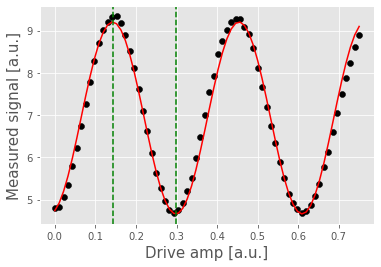


pi_amp_real = 0.15565158089059916



In [132]:

fit_params, y_fit = fit_function(drive_amps,
                                 np.real(rabi_values), 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.3, 0])

drive_period = fit_params[2] # get period of rabi oscillation
fit_phi = fit_params[3] 

plt.scatter(drive_amps, np.real(rabi_values), color='black')
plt.plot(drive_amps, y_fit, color='red')

xi = drive_period/(2*np.pi)*(np.pi+fit_phi)
xf = drive_period/(2*np.pi)*(2*np.pi+fit_phi)

plt.axvline(xi, color='green', linestyle='--')
plt.axvline(xf, color='green', linestyle='--')
# plt.annotate("", xy=(xi, 0), xytext=(xf,0), arrowprops=dict(arrowstyle="<->", color='red'))
# plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)

pi_amp_real = abs(drive_period / 2)

plt.show()

print(f"\npi_amp_real = {pi_amp_real}\n")


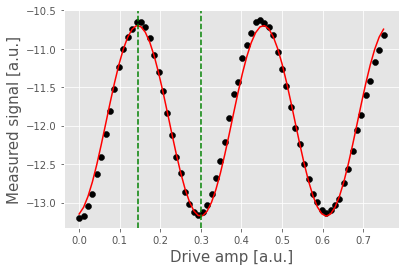


pi_amp_imag = 0.15487674492868675



In [133]:
fit_params, y_fit = fit_function(drive_amps,
                                 np.imag(rabi_values), 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.3, 0])

drive_period = fit_params[2] # get period of rabi oscillation
fit_phi = fit_params[3] 

plt.scatter(drive_amps, np.imag(rabi_values), color='black')
plt.plot(drive_amps, y_fit, color='red')

xi = drive_period/(2*np.pi)*(np.pi+fit_phi)
xf = drive_period/(2*np.pi)*(2*np.pi+fit_phi)

plt.axvline(xi, color='green', linestyle='--')
plt.axvline(xf, color='green', linestyle='--')

# plt.annotate("", xy=(xi, 15), xytext=(xf,15), arrowprops=dict(arrowstyle="<->", color='red'))
# plt.annotate("$\pi$", xy=(drive_period/2-0.03, 15), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)

pi_amp_imag = abs(drive_period / 2)

plt.show()

print(f"\npi_amp_imag = {pi_amp_imag}\n")


In [134]:
pi_amp = (pi_amp_real + pi_amp_imag)/2
pi_amp_delta = np.abs((pi_amp_real - pi_amp_imag)/2)

display(pi_amp)
display(pi_amp_delta)

0.15526416290964296

0.00038741798095620616

## Our  $\pi$  pulse!

In [139]:
with pulse.build(backend) as pi_pulse:
    #
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    #
    pulse.play(pulse.Gaussian(duration = drive_duration,
                              amp = pi_amp,
                              sigma = drive_sigma,
                              name = 'pi_pulse'), drive_chan)
        

# Determining 0 vs 1

In [203]:
ramsey_qubit_freq

4971643386.331432

In [204]:
rough_qubit_frequency
print(rough_qubit_frequency/GHz,ramsey_qubit_freq/GHz)

4.971637817326412 4.971643386331432


In [205]:
# Create two schedules


ramsey_qubit_freq = 4.971638 * GHz


# Ground state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='ground state') as gnd_schedule:
    drive_chan = pulse.drive_channel(qubit)
    #
#     pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.set_frequency(ramsey_qubit_freq, drive_chan)       # New ramsey_qubit_freq
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])


# Excited state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    #
    drive_chan = pulse.drive_channel(qubit)
#     pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.set_frequency(ramsey_qubit_freq, drive_chan)       # New ramsey_qubit_freq
    pulse.call(pi_pulse)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])
    
    

def gnd_schedule_batch(n):                                   
    tab = []                                                   
    for k in range(0, n):             
        tab.append(gnd_schedule)
    return tab  

def exc_schedule_batch(n):                                   
    tab = []                                                   
    for k in range(0, n):             
        tab.append(exc_schedule)
    return tab  

In [206]:
# Execution settings


batch_num = 35
num_shots = 8192

job_det = backend.run(gnd_schedule_batch(batch_num)+exc_schedule_batch(batch_num), 
                  meas_level = 1, 
                  meas_return = 'single', 
                  shots = num_shots)

print(job_det.job_id())
job_monitor(job_det)


time.ctime()     

613a559521fb765767779a7f
Job Status: job has successfully run


'Thu Sep  9 15:53:55 2021'

In [289]:
gnd_exc_results = job_det.result(timeout=120)

In [290]:
gnd_results = []
for i in range(0, batch_num): # (0, batch_num)
    gnd_results.extend(gnd_exc_results.get_memory(i)[:, qubit]*scale_factor)

exc_results = []
for i in range(batch_num, 2*batch_num): # (batch_num, 2*batch_num)
    exc_results.extend(gnd_exc_results.get_memory(i)[:, qubit]*scale_factor)




mean_gnd = np.mean(gnd_results) 
mean_exc = np.mean(exc_results)

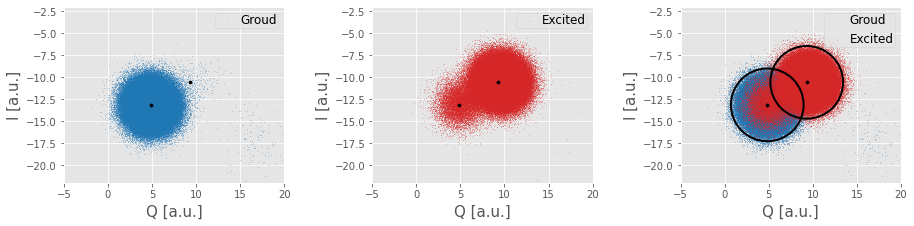

In [294]:
%matplotlib inline

fig = plt.figure()

fig.set_figheight(15)
fig.set_figwidth(15)

ax1 = fig.add_subplot(1,3,1, aspect=1)
ax2 = fig.add_subplot(1,3,2, aspect=1)
ax3 = fig.add_subplot(1,3,3, aspect=1)



x2 = np.real(mean_gnd) 
y2 = np.imag(mean_gnd) 

x1 = np.real(mean_exc) 
y1 = np.imag(mean_exc) 


r1 = 0.8 * distance(mean_gnd, mean_exc)

circle_gnd_r1 = plt.Circle((np.real(mean_gnd), np.imag(mean_gnd)), r1, color='black', fill=False,  lw=2)
circle_exc_r1 = plt.Circle((np.real(mean_exc), np.imag(mean_exc)), r1, color='black', fill=False,  lw=2)

# ax1.add_patch(circle_gnd_r1)
# ax1.add_patch(circle_exc_r1)
# ax2.add_patch(circle_gnd_r1)
# ax2.add_patch(circle_exc_r1)
ax3.add_patch(circle_gnd_r1)
ax3.add_patch(circle_exc_r1)



ax1.scatter(np.real(gnd_results), np.imag(gnd_results), 
            s=0.1, cmap='viridis', c='tab:blue', alpha=0.5, label='Groud')

ax2.scatter(np.real(exc_results), np.imag(exc_results), 
            s=0.1, cmap='viriscale_factordis', c='tab:red', alpha=0.5, label='Excited')

ax3.scatter(np.real(gnd_results), np.imag(gnd_results), 
            s=0.1, cmap='viridis', c='tab:blue', alpha=0.5, label='Groud')

ax3.scatter(np.real(exc_results), np.imag(exc_results), 
            s=0.1, cmap='viriscale_factordis', c='tab:red', alpha=0.5, label='Excited')


# mean point
ax1.scatter(np.real(mean_gnd), np.imag(mean_gnd), s=10, cmap='viridis', c='k', alpha=1.0)
ax1.scatter(np.real(mean_exc), np.imag(mean_exc), s=10, cmap='viridis', c='k', alpha=1.0)
ax2.scatter(np.real(mean_gnd), np.imag(mean_gnd), s=10, cmap='viridis', c='k',alpha=1.0)
ax2.scatter(np.real(mean_exc), np.imag(mean_exc), s=10, cmap='viridis', c='k',alpha=1.0)
ax3.scatter(np.real(mean_gnd), np.imag(mean_gnd), s=10, cmap='viridis', c='k',alpha=1.0)
ax3.scatter(np.real(mean_exc), np.imag(mean_exc), s=10, cmap='viridis', c='k',alpha=1.0)





ax1.set_xlim([-5, 20])
ax1.set_ylim([-22, -2])

ax2.set_xlim([-5, 20])
ax2.set_ylim([-22, -2])

ax3.set_xlim([-5, 20])
ax3.set_ylim([-22, -2])



ax1.set_ylabel('I [a.u.]', fontsize=15)
ax1.set_xlabel('Q [a.u.]', fontsize=15)
ax2.set_ylabel('I [a.u.]', fontsize=15)
ax2.set_xlabel('Q [a.u.]', fontsize=15)
ax3.set_ylabel('I [a.u.]', fontsize=15)
ax3.set_xlabel('Q [a.u.]', fontsize=15)


ax1.legend(fontsize=12, loc='upper right', borderpad=0.1, handletextpad=0.05)
ax2.legend(fontsize=12, loc='upper right', borderpad=0.1, handletextpad=0.05)
ax3.legend(fontsize=12, loc='upper right', borderpad=0.1, handletextpad=0.05)


plt.subplots_adjust(wspace=0.4)

#plt.savefig('comparing.png', dpi=400, bbox_inches = 'tight')


# Show graphic
plt.show();

In [167]:

def gnd_error_v1(gnd_results):   
    a = classify_v1_map(gnd_results, mean_gnd, mean_exc)['1']
    b = classify_v1_map(gnd_results, mean_gnd, mean_exc)['0']
    c = a/(a+b)
    return c

def exc_error_v1(exc_results):   
    a = classify_v1_map(exc_results, mean_gnd, mean_exc)['1']
    b = classify_v1_map(exc_results, mean_gnd, mean_exc)['0']
    c = b/(a+b)
    return c


def gnd_error_v2(gnd_results,dis):   
    a = classify_v2_map(gnd_results, dis, mean_gnd, mean_exc)['1']
    b = classify_v2_map(gnd_results, dis, mean_gnd, mean_exc)['0']
    c = a/(a+b)
    return c

def exc_error_v2(exc_results,dis):   
    a = classify_v2_map(exc_results, dis, mean_gnd, mean_exc)['1']
    b = classify_v2_map(exc_results, dis, mean_gnd, mean_exc)['0']
    c = b/(a+b)
    return c


def gnd_error_v3(gnd_results,dis):   
    a = classify_v3_map(gnd_results, dis, mean_gnd, mean_exc)['1']
    b = classify_v3_map(gnd_results, dis, mean_gnd, mean_exc)['0']
    c = a/(a+b)
    return c

def exc_error_v3(exc_results,dis):   
    a = classify_v3_map(exc_results, dis, mean_gnd, mean_exc)['1']
    b = classify_v3_map(exc_results, dis, mean_gnd, mean_exc)['0']
    c = b/(a+b)
    return c

def exc_despised_shots_v2(exc_results, dis):   
    return classify_v2_map(exc_results, dis, mean_gnd, mean_exc)["<class 'ValueError'>"]

def gnd_despised_shots_v2(gnd_results, dis):   
    return classify_v2_map(gnd_results, dis, mean_gnd, mean_exc)["<class 'ValueError'>"]


def exc_valid_shots_v2(exc_results, dis):
    a = classify_v2_map(exc_results, dis, mean_gnd, mean_exc)['1']
    b = classify_v2_map(exc_results, dis, mean_gnd, mean_exc)['0']
    return a+b

def gnd_valid_shots_v2(gnd_results, dis):
    a = classify_v2_map(gnd_results, dis, mean_gnd, mean_exc)['1']
    b = classify_v2_map(gnd_results, dis, mean_gnd, mean_exc)['0']
    return a+b

def exc_despised_shots_v3(exc_results, dis):   
    return classify_v3_map(exc_results, dis, mean_gnd, mean_exc)["<class 'ValueError'>"]

def gnd_despised_shots_v3(gnd_results, dis):   
    return classify_v3_map(gnd_results, dis, mean_gnd, mean_exc)["<class 'ValueError'>"]

def exc_valid_shots_v3(exc_results, dis):
    a = classify_v3_map(exc_results, dis, mean_gnd, mean_exc)['1']
    b = classify_v3_map(exc_results, dis, mean_gnd, mean_exc)['0']
    return a+b

def gnd_valid_shots_v3(gnd_results, dis):
    a = classify_v3_map(gnd_results, dis, mean_gnd, mean_exc)['1']
    b = classify_v3_map(gnd_results, dis, mean_gnd, mean_exc)['0']
    return a+b
    

In [186]:
factor_i=  0.01
factor_f = 1.3
factor_n = 40
factor_list = np.linspace(factor_i, factor_f, factor_n)

point_num = 10000

list_gnd_error_v2 = []
for i in factor_list:
#     gnd_error_v2(gnd_results[0:point_num], i)    
    list_gnd_error_v2.append(gnd_error_v2(gnd_results[0:point_num], i))
    
list_exc_error_v2 = []
for i in factor_list:
    list_exc_error_v2.append(exc_error_v2(exc_results[0:point_num], i))    
    
list_gnd_error_v3 = []
for i in factor_list:
    list_gnd_error_v3.append(gnd_error_v3(gnd_results[0:point_num], i))
    
list_exc_error_v3 = []
for i in factor_list:
    list_exc_error_v3.append(exc_error_v3(exc_results[0:point_num], i))    
    
# --------------------------------------------------    

list_gnd_despised_shots_v2 = [] 
for i in factor_list:
    list_gnd_despised_shots_v2.append(exc_despised_shots_v2(gnd_results[0:point_num], i))     
    
list_gnd_despised_shots_v3 = [] 
for i in factor_list:
    list_gnd_despised_shots_v3.append(exc_despised_shots_v3(gnd_results[0:point_num], i))         
    

In [173]:
    
# list_exc_valid_shots_v2 = []
# for i in factor_list:
#     list_exc_valid_shots_v2.append(exc_valid_shots_v2(exc_results[0:point_num], i))

# list_exc_valid_shots_v3 = []
# for i in factor_list:
#     list_exc_valid_shots_v3.append(exc_valid_shots_v3(exc_results[0:point_num], i))    
    
# list_gnd_valid_shots_v2 = []
# for i in factor_list:
#     list_gnd_valid_shots_v2.append(gnd_valid_shots_v2(gnd_results[0:point_num], i))

# list_gnd_valid_shots_v3 = []
# for i in factor_list:
#     list_gnd_valid_shots_v3.append(gnd_valid_shots_v3(gnd_results[0:point_num], i))        
    
    
# list_exc_despised_shots_v2 = [] 
# for i in factor_list:
#     list_exc_despised_shots_v2.append(exc_despised_shots_v2(exc_results[0:point_num], i))     
    
# list_exc_despised_shots_v3 = [] 
# for i in factor_list:
#     list_exc_despised_shots_v3.append(exc_despised_shots_v3(exc_results[0:point_num], i))         
            


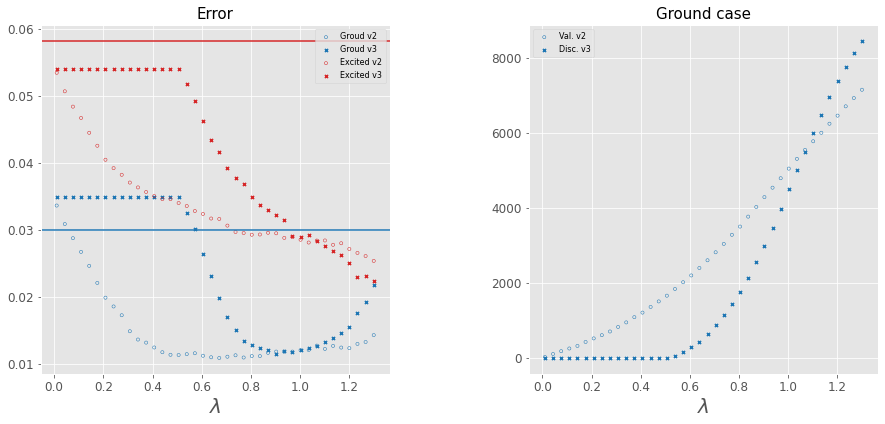

In [187]:
%matplotlib inline


fig = plt.figure()

fig.set_figheight(15)
fig.set_figwidth(15)

plt.style.use('ggplot')
# plt.style.use('default')
    
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
# ax3 = fig.add_subplot(1,3,3)


ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
# ax3.tick_params(labelsize=12)


ax1.scatter(factor_list, list_gnd_error_v2, color='tab:blue', label='Groud v2', s=10, marker="o", facecolors='none')
ax1.scatter(factor_list, list_gnd_error_v3, color='tab:blue', label='Groud v3', s=10, marker="x")
ax1.scatter(factor_list, list_exc_error_v2, color='tab:red', label='Excited v2', s=10, marker="o", facecolors='none') 
ax1.scatter(factor_list, list_exc_error_v3, color='tab:red', label='Excited v3', s=10, marker="x") 


# ax2.scatter(factor_list, list_gnd_valid_shots_v2, color='tab:red', label='Val. v2', s=10, marker="o", facecolors='none')  
# ax2.scatter(factor_list, list_gnd_valid_shots_v3, color='tab:red', label='Disc. v3', s=10, marker="x") 
ax2.scatter(factor_list, list_gnd_despised_shots_v2, color='tab:blue', label='Val. v2', s=10, marker="o", facecolors='none')  
ax2.scatter(factor_list, list_gnd_despised_shots_v3, color='tab:blue', label='Disc. v3', s=10, marker="x") 


# ax3.scatter(factor_list, list_exc_valid_shots_v2, color='tab:red', label='Val. v2', s=10, marker="o", facecolors='none') 
# ax3.scatter(factor_list, list_exc_valid_shots_v3, color='tab:red', label='Val. v3', s=10, marker="x") 
# ax3.scatter(factor_list, list_exc_despised_shots_v2, color='tab:blue', label='Disc v2.', s=10, marker="o", facecolors='none')
# ax3.scatter(factor_list, list_exc_despised_shots_v3, color='tab:blue', label='Disc. v3', s=10, marker="x")



plt.subplots_adjust(wspace=0.4)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
# ax3.set_box_aspect(1)


#x1.set_ylabel('', fontsize=20)
ax1.set_xlabel('$\lambda$', fontsize=20)
ax2.set_xlabel('$\lambda$', fontsize=20)
# ax3.set_xlabel('$\lambda$', fontsize=20)

ax1.legend(fontsize=8,  loc='upper right', )
ax2.legend(fontsize=8)
# ax3.legend(fontsize=8)

ax1.set_title("Error", fontsize=15)
ax2.set_title("Ground case", fontsize=15)
# ax3.set_title("Excited case", fontsize=15)

ax1.axhline( gnd_error_v1(gnd_results), color="tab:blue")

ax1.axhline( exc_error_v1(exc_results), color="tab:red")


  
# plt.savefig('error.png', dpi=400, bbox_inches = 'tight')

plt.show()

## Measuring the qubit Frequency Precisely using a Ramsey Experiment

In [195]:
# Ramsey experiment parameters

time_max_sec = 1.8 * us
time_step_sec = 0.025 * us
delay_times_sec = np.arange(0.1 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    #
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    #
    pulse.play(pulse.Gaussian(
                                duration = drive_duration,
                                amp = drive_amp,
                                sigma = drive_sigma,
                                name = 'x90_pulse'), drive_chan)

In [196]:
detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz
ramsey_frequency

4973637817.326412

In [197]:
# create schedules for Ramsey experiment 

ramsey_schedules = []
for delay in delay_times_sec:
    with pulse.build(backend=backend, default_alignment='sequential', name=f"Ramsey delay = {delay / ns} ns") as ramsey_schedule:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(ramsey_frequency, drive_chan)
        pulse.call(x90_pulse)
        pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay)), drive_chan)
        pulse.call(x90_pulse)
        pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])
    ramsey_schedules.append(ramsey_schedule)

In [198]:
# Execution settings
num_shots = 8192

job_ramsey = backend.run(ramsey_schedules, 
                  meas_level = 1, 
                  meas_return = 'single', 
                  shots = num_shots)


print(job_ramsey.job_id())
job_monitor(job_ramsey)

time.ctime()     

613a4d0117e5889592ba2dd0
Job Status: job has successfully run


'Thu Sep  9 15:32:04 2021'

In [199]:
ramsey_results = job_ramsey.result(timeout=120)

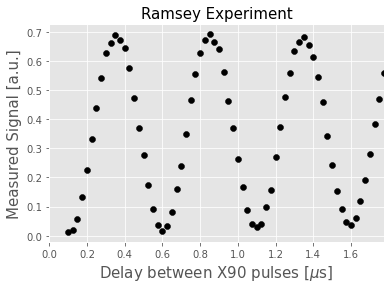

In [200]:
ramsey_values = []
for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    # Classify V1
#     ramsey_values.append(sum(map(classify_v1, iq_data)) / num_shots)
    # Classify V2
    # val_num_shots = Counter([classify_v2(iq_data[j], 1/2) for j in range(0,len(iq_data))])[1]+Counter([classify_v2(iq_data[j], 1/2) for j in range(0,len(iq_data))])[0]
    val_num_shots = classify_v3_map(iq_data, 0.8, mean_gnd, mean_exc)['0']+\
                    classify_v3_map(iq_data, 0.8, mean_gnd, mean_exc)['1']
    num_exc = classify_v3_map(iq_data, 0.8, mean_gnd, mean_exc)['1']
    ramsey_values.append(num_exc / val_num_shots)


plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

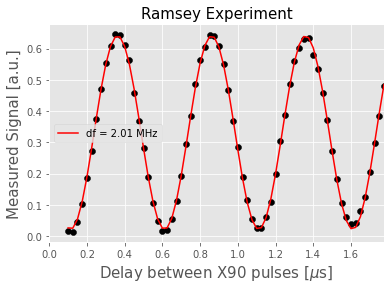

In [77]:
fit_params, y_fit = fit_function(delay_times_sec/us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 1./0.4, 0, 0.25]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(delay_times_sec/us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [201]:
ramsey_qubit_freq = rough_qubit_frequency + (del_f_MHz - detuning_MHz) * MHz # get new freq in Hz

print(f"First  {round(center_frequency_Hz / GHz, 6)} GHz")
print(f"Second {round(rough_qubit_frequency / GHz, 6)} GHz")
print(f"Third  {round(ramsey_qubit_freq / GHz, 6)} GHz.")

# 4.971638 GHz.
# 4.971643 

First  4.971604 GHz
Second 4.971638 GHz
Third  4.971643 GHz.


In [202]:
ramsey_qubit_freq

4971643386.331432

## Filter

In [210]:
dic_gnd = {**{'0': 0}, **{'1': 0}, **{"<class 'ValueError'>": 0}, **dict(Counter([f'{classify_v3(gnd_results[i], 0.75, mean_gnd, mean_exc)}' for i in range(0,len(gnd_results))]))}
dic_exc = {**{'0': 0}, **{'1': 0}, **{"<class 'ValueError'>": 0}, **dict(Counter([f'{classify_v3(exc_results[i], 0.75, mean_gnd, mean_exc)}' for i in range(0,len(exc_results))]))}

del dic_gnd["<class 'ValueError'>"]
del dic_exc["<class 'ValueError'>"]

In [211]:
v1 = np.array(list(dic_gnd.values()  ))/sum(np.array(list(dic_gnd.values())))
v2 = np.array(list(dic_exc.values()  ))/sum(np.array(list(dic_exc.values())))
display(v1)
display(v2)

array([0.99335706, 0.00664294])

array([0.04212094, 0.95787906])

In [212]:
mat_filt = np.linalg.inv(np.transpose([v1,v2]))

In [213]:
mat_filt

array([[ 1.00698348, -0.04428022],
       [-0.00698348,  1.04428022]])

In [87]:
mat_filt

array([[ 1.00730943, -0.03610621],
       [-0.00730943,  1.03610621]])

In [383]:
mat_filt

array([[ 1.00530907, -0.03273725],
       [-0.00530907,  1.03273725]])

In [228]:
np.savetxt('mat_filt.csv', mat_filt, delimiter=',')
np.savetxt('ramsey_frequency.csv', [ramsey_frequency])
np.savetxt('mean_gnd.csv', [mean_gnd],  delimiter=',')
np.savetxt('mean_exc.csv', [mean_exc],  delimiter=',')

#response = np.genfromtxt('power_rabi_demo_v2.csv', delimiter=',', dtype=complex)    
# A CSV (comma-separated values) file is a simple text file in which information 
# is separated by commas. CSV files are most commonly encountered in spreadsheets and databases. 
# You can use a CSV file to move data between programs that aren't ordinarily able to exchange data.

In [230]:
display(mat_filt)
display(ramsey_frequency)
display(mean_gnd)
display(mean_exc)

array([[ 1.00698348, -0.04428022],
       [-0.00698348,  1.04428022]])

4973637817.326412

(4.827094446896466-13.15435560787734j)

(9.306859328112544-10.598781935976447j)

In [229]:
mean_gnd

(4.827094446896466-13.15435560787734j)

# PART 2

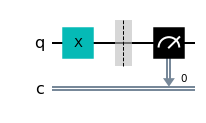

In [400]:
circ = QuantumCircuit(1,1)
circ.x(0)
circ.barrier(0);
circ.measure(0,0)


circ.draw('mpl')

In [401]:
schedule(transpile(circ, backend), backend)

Schedule((0, Play(Drag(duration=320, amp=(0.9100048506484596+0j), sigma=80, beta=-1.00480943736885, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), (320, Acquire(22400, AcquireChannel(0), MemorySlot(0))), (320, Play(GaussianSquare(duration=22400, amp=(0.26625217802280143+0.22717785477047367j), sigma=64, width=22144, name='M_m0'), MeasureChannel(0), name='M_m0')), name="circuit-117")

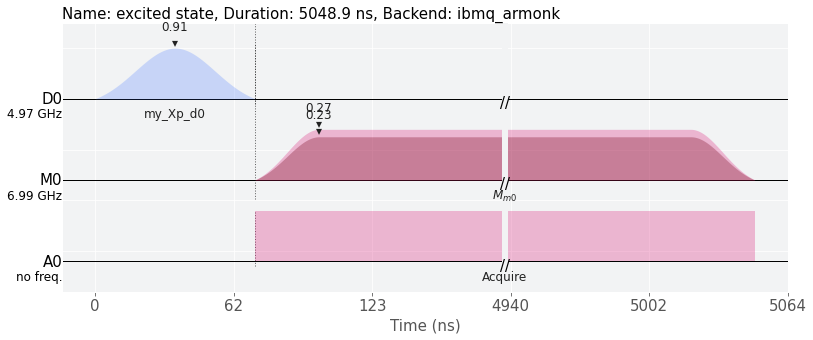

In [277]:
d0 = pulse.DriveChannel(0)
m0 = pulse.MeasureChannel(0)
a0 = pulse.AcquireChannel(0)
mem_slot = 0



my_Xp_d0 = pulse.Drag(duration = 320,
                              amp = 0.9100048506484596,
                              sigma = 80,
                              beta = -1.00480943736885,
                              name = 'my_Xp_d0')

my_M_m0 = pulse.GaussianSquare(duration=22400, 
                               amp=(0.26625217802280143+0.22717785477047367j),
                               sigma = 64,
                               width = 22144, 
                               name = '$M_{m0}$')


# Ground state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='ground state') as gnd_schedule:
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])


# Excited state schedule
with pulse.build(backend=backend,  name='excited state') as exc_schedule:
    #
    pulse.play(my_Xp_d0, d0)
    # Measurement! 
    pulse.barrier(d0,m0)
    pulse.barrier(d0,a0)
    pulse.play(my_M_m0, m0)
    pulse.acquire(22400, a0, pulse.MemorySlot(mem_slot))

    
exc_schedule.draw(style=IQXDebugging(), backend=backend)   

In [278]:
def gnd_schedule_batch(n):                                   
    tab = []                                                   
    for k in range(0, n):             
        tab.append(gnd_schedule)
    return tab  

def exc_schedule_batch(n):                                   
    tab = []                                                   
    for k in range(0, n):             
        tab.append(exc_schedule)
    return tab  

In [281]:
# Execution settings


batch_num = 35
num_shots = 8192

job_xgate = backend.run(gnd_schedule_batch(batch_num)+exc_schedule_batch(batch_num), 
                  meas_level = 1, 
                  meas_return = 'single', 
                  shots = num_shots)

print(job_xgate.job_id())
job_monitor(job_xgate)


time.ctime()     

613a7f24822822334ae1fb1c
Job Status: job has successfully run


'Thu Sep  9 18:52:40 2021'

In [388]:
gnd_exc_results_xgate = job_xgate.result(timeout=120)

In [389]:
gnd_results = []
for i in range(0, batch_num): # (0, batch_num)
    gnd_results.extend(gnd_exc_results_xgate.get_memory(i)[:, qubit]*scale_factor)

exc_results = []
for i in range(batch_num, 2*batch_num): # (batch_num, 2*batch_num)
    exc_results.extend(gnd_exc_results_xgate.get_memory(i)[:, qubit]*scale_factor)




mean_gnd = np.mean(gnd_results) 
mean_exc = np.mean(exc_results)

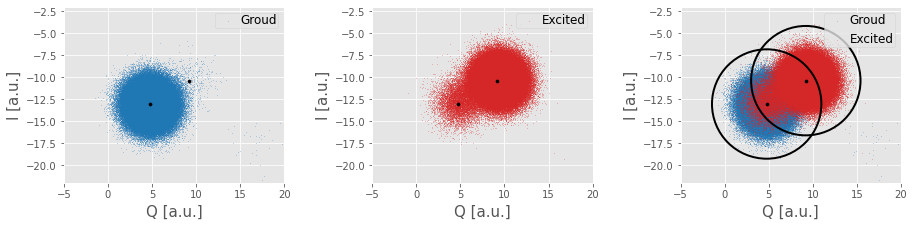

In [390]:
%matplotlib inline

fig = plt.figure()

fig.set_figheight(15)
fig.set_figwidth(15)

ax1 = fig.add_subplot(1,3,1, aspect=1)
ax2 = fig.add_subplot(1,3,2, aspect=1)
ax3 = fig.add_subplot(1,3,3, aspect=1)



x2 = np.real(mean_gnd) 
y2 = np.imag(mean_gnd) 

x1 = np.real(mean_exc) 
y1 = np.imag(mean_exc) 


r1 = 1.2 * distance(mean_gnd, mean_exc)

circle_gnd_r1 = plt.Circle((np.real(mean_gnd), np.imag(mean_gnd)), r1, color='black', fill=False,  lw=2)
circle_exc_r1 = plt.Circle((np.real(mean_exc), np.imag(mean_exc)), r1, color='black', fill=False,  lw=2)

# ax1.add_patch(circle_gnd_r1)
# ax1.add_patch(circle_exc_r1)
# ax2.add_patch(circle_gnd_r1)
# ax2.add_patch(circle_exc_r1)
ax3.add_patch(circle_gnd_r1)
ax3.add_patch(circle_exc_r1)



ax1.scatter(np.real(gnd_results), np.imag(gnd_results), 
            s=0.1, cmap='viridis', c='tab:blue', alpha=0.5, label='Groud')

ax2.scatter(np.real(exc_results), np.imag(exc_results), 
            s=0.1, cmap='viriscale_factordis', c='tab:red', alpha=0.5, label='Excited')

ax3.scatter(np.real(gnd_results), np.imag(gnd_results), 
            s=0.1, cmap='viridis', c='tab:blue', alpha=0.5, label='Groud')

ax3.scatter(np.real(exc_results), np.imag(exc_results), 
            s=0.1, cmap='viriscale_factordis', c='tab:red', alpha=0.5, label='Excited')


# mean point
ax1.scatter(np.real(mean_gnd), np.imag(mean_gnd), s=10, cmap='viridis', c='k', alpha=1.0)
ax1.scatter(np.real(mean_exc), np.imag(mean_exc), s=10, cmap='viridis', c='k', alpha=1.0)
ax2.scatter(np.real(mean_gnd), np.imag(mean_gnd), s=10, cmap='viridis', c='k',alpha=1.0)
ax2.scatter(np.real(mean_exc), np.imag(mean_exc), s=10, cmap='viridis', c='k',alpha=1.0)
ax3.scatter(np.real(mean_gnd), np.imag(mean_gnd), s=10, cmap='viridis', c='k',alpha=1.0)
ax3.scatter(np.real(mean_exc), np.imag(mean_exc), s=10, cmap='viridis', c='k',alpha=1.0)



ax1.set_xlim([-5, 20])
ax1.set_ylim([-22, -2])

ax2.set_xlim([-5, 20])
ax2.set_ylim([-22, -2])

ax3.set_xlim([-5, 20])
ax3.set_ylim([-22, -2])



ax1.set_ylabel('I [a.u.]', fontsize=15)
ax1.set_xlabel('Q [a.u.]', fontsize=15)
ax2.set_ylabel('I [a.u.]', fontsize=15)
ax2.set_xlabel('Q [a.u.]', fontsize=15)
ax3.set_ylabel('I [a.u.]', fontsize=15)
ax3.set_xlabel('Q [a.u.]', fontsize=15)


ax1.legend(fontsize=12, loc='upper right', borderpad=0.1, handletextpad=0.05)
ax2.legend(fontsize=12, loc='upper right', borderpad=0.1, handletextpad=0.05)
ax3.legend(fontsize=12, loc='upper right', borderpad=0.1, handletextpad=0.05)


plt.subplots_adjust(wspace=0.4)

#plt.savefig('comparing.png', dpi=400, bbox_inches = 'tight')


# Show graphic
plt.show();

In [391]:
factor_i=  0.01
factor_f = 1.3
factor_n = 40
factor_list = np.linspace(factor_i, factor_f, factor_n)

point_num = 20000

list_gnd_error_v2 = []
for i in factor_list:
#     gnd_error_v2(gnd_results[0:point_num], i)    
    list_gnd_error_v2.append(gnd_error_v2(gnd_results[0:point_num], i))
    
list_exc_error_v2 = []
for i in factor_list:
    list_exc_error_v2.append(exc_error_v2(exc_results[0:point_num], i))    
    
list_gnd_error_v3 = []
for i in factor_list:
    list_gnd_error_v3.append(gnd_error_v3(gnd_results[0:point_num], i))
    
list_exc_error_v3 = []
for i in factor_list:
    list_exc_error_v3.append(exc_error_v3(exc_results[0:point_num], i))    
    
# --------------------------------------------------    

list_gnd_despised_shots_v2 = [] 
for i in factor_list:
    list_gnd_despised_shots_v2.append(exc_despised_shots_v2(gnd_results[0:point_num], i))     
    
list_gnd_despised_shots_v3 = [] 
for i in factor_list:
    list_gnd_despised_shots_v3.append(exc_despised_shots_v3(gnd_results[0:point_num], i))    

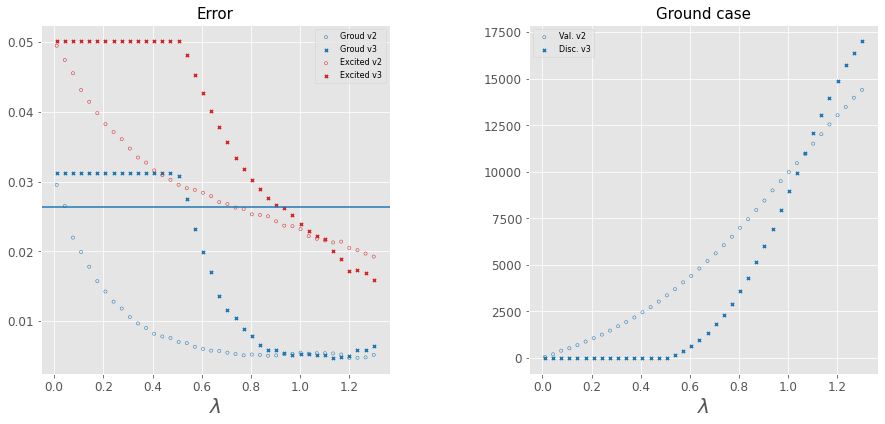

In [392]:
%matplotlib inline


fig = plt.figure()

fig.set_figheight(15)
fig.set_figwidth(15)

plt.style.use('ggplot')
# plt.style.use('default')
    
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

ax1.scatter(factor_list, list_gnd_error_v2, color='tab:blue', label='Groud v2', s=10, marker="o", facecolors='none')
ax1.scatter(factor_list, list_gnd_error_v3, color='tab:blue', label='Groud v3', s=10, marker="x")
ax1.scatter(factor_list, list_exc_error_v2, color='tab:red', label='Excited v2', s=10, marker="o", facecolors='none') 
ax1.scatter(factor_list, list_exc_error_v3, color='tab:red', label='Excited v3', s=10, marker="x") 

ax2.scatter(factor_list, list_gnd_despised_shots_v2, color='tab:blue', label='Val. v2', s=10, marker="o", facecolors='none')  
ax2.scatter(factor_list, list_gnd_despised_shots_v3, color='tab:blue', label='Disc. v3', s=10, marker="x") 

plt.subplots_adjust(wspace=0.4)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)

#x1.set_ylabel('', fontsize=20)
ax1.set_xlabel('$\lambda$', fontsize=20)
ax2.set_xlabel('$\lambda$', fontsize=20)
# ax3.set_xlabel('$\lambda$', fontsize=20)

ax1.legend(fontsize=8,  loc='upper right', )
ax2.legend(fontsize=8)

ax1.set_title("Error", fontsize=15)
ax2.set_title("Ground case", fontsize=15)

ax1.axhline( gnd_error_v1(gnd_results), color="tab:blue")
ax1.axhline( exc_error_v1(exc_results), color="tab:red")


  
# plt.savefig('error.png', dpi=400, bbox_inches = 'tight')

plt.show()

## Filter

In [393]:
LAMBDA = 1.3 

dic_gnd = {**{'0': 0}, **{'1': 0}, **{"<class 'ValueError'>": 0}, 
           **dict(Counter([f'{classify_v3(gnd_results[i], LAMBDA, mean_gnd, mean_exc)}' for i in range(0,len(gnd_results))]))}
dic_exc = {**{'0': 0}, **{'1': 0}, **{"<class 'ValueError'>": 0},  
           **dict(Counter([f'{classify_v3(exc_results[i], LAMBDA, mean_gnd, mean_exc)}' for i in range(0,len(exc_results))]))}

del dic_gnd["<class 'ValueError'>"]
del dic_exc["<class 'ValueError'>"]

In [394]:
v1 = np.array(list(dic_gnd.values()  ))/sum(np.array(list(dic_gnd.values())))
v2 = np.array(list(dic_exc.values()  ))/sum(np.array(list(dic_exc.values())))
display(v1)
display(v2)

array([0.99752557, 0.00247443])

array([0.02057501, 0.97942499])

In [395]:
mat_filt = np.linalg.inv(np.transpose([v1,v2]))

In [396]:
mat_filt

array([[ 1.00253281, -0.02106044],
       [-0.00253281,  1.02106044]])

In [311]:
mat_filt

array([[ 1.00435629, -0.02629465],
       [-0.00435629,  1.02629465]])

In [87]:
mat_filt

array([[ 1.00730943, -0.03610621],
       [-0.00730943,  1.03610621]])

In [383]:
mat_filt

array([[ 1.00530907, -0.03273725],
       [-0.00530907,  1.03273725]])

In [397]:
np.savetxt('mat_filt.csv', mat_filt, delimiter=',')
np.savetxt('ramsey_frequency.csv', [ramsey_frequency])
np.savetxt('mean_gnd.csv', [mean_gnd],  delimiter=',')
np.savetxt('mean_exc.csv', [mean_exc],  delimiter=',')
np.savetxt('LAMBDA.csv', [LAMBDA],  delimiter=',')


#response = np.genfromtxt('power_rabi_demo_v2.csv', delimiter=',', dtype=complex)    
# A CSV (comma-separated values) file is a simple text file in which information 
# is separated by commas. CSV files are most commonly encountered in spreadsheets and databases. 
# You can use a CSV file to move data between programs that aren't ordinarily able to exchange data.

In [313]:
display(mat_filt)
display(ramsey_frequency)
display(mean_gnd)
display(mean_exc)

array([[ 1.00435629, -0.02629465],
       [-0.00435629,  1.02629465]])

4973637817.326412

(4.742059267500861-13.035304546701894j)

(9.221222371378065-10.364140967724179j)

In [307]:
display(mat_filt)
display(ramsey_frequency)
display(mean_gnd)
display(mean_exc)

array([[ 1.00593098, -0.02895338],
       [-0.00593098,  1.02895338]])

4973637817.326412

(4.742059267500861-13.035304546701894j)

(9.221222371378065-10.364140967724179j)

# PART 3 

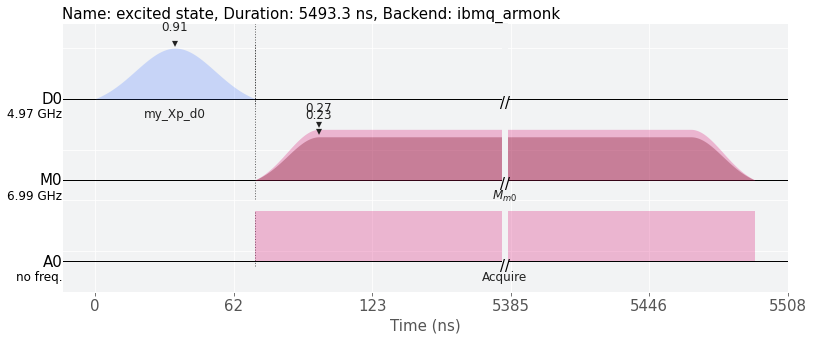

In [351]:
d0 = pulse.DriveChannel(0)
m0 = pulse.MeasureChannel(0)
a0 = pulse.AcquireChannel(0)
mem_slot = 0




my_Xp_d0 = pulse.Drag(duration = 320,
                              amp = 0.9100048506484596,
                              sigma = 80,
                              beta = -1.00480943736885,
                              name = 'my_Xp_d0')

my_M_m0 = pulse.GaussianSquare(duration = 24400,  # 22400, 
                               amp=(0.26625217802280143+0.22717785477047367j),
                               sigma = 64,
                               width = 24144,  # 22144
                               name = '$M_{m0}$')


# Ground state schedule
with pulse.build(backend=backend, name='ground state') as gnd_schedule:
    pulse.play(my_M_m0, m0)
    pulse.acquire(24400, a0, pulse.MemorySlot(mem_slot))


# Excited state schedule
with pulse.build(backend=backend,  name='excited state') as exc_schedule:
    #
    pulse.play(my_Xp_d0, d0)
    # Measurement! 
    pulse.barrier(d0,m0)
    pulse.barrier(d0,a0)
    pulse.play(my_M_m0, m0)
    pulse.acquire(24400, a0, pulse.MemorySlot(mem_slot))

    
exc_schedule.draw(style=IQXDebugging(), backend=backend)   

In [352]:
def gnd_schedule_batch(n):                                   
    tab = []                                                   
    for k in range(0, n):             
        tab.append(gnd_schedule)
    return tab  

def exc_schedule_batch(n):                                   
    tab = []                                                   
    for k in range(0, n):             
        tab.append(exc_schedule)
    return tab  

In [353]:
# Execution settings


batch_num = 35
num_shots = 8192

job_xgate = backend.run(gnd_schedule_batch(batch_num)+exc_schedule_batch(batch_num), 
                  meas_level = 1, 
                  meas_return = 'single', 
                  shots = num_shots)

print(job_xgate.job_id())
job_monitor(job_xgate)


time.ctime()     

613a9fef21fb7663cd779df9
Job Status: job has successfully run


'Thu Sep  9 21:13:00 2021'

In [354]:
gnd_exc_results_xgate_long = job_xgate.result(timeout=120)

In [363]:
gnd_results = []
for i in range(4, 5): #   # (0, 1)  # (0, batch_num)
    gnd_results.extend(gnd_exc_results_xgate_long.get_memory(i)[:, qubit]*scale_factor)

exc_results = []
for i in range(batch_num+3, batch_num+4): #  # (batch_num, batch_num+1)  # (batch_num, 2*batch_num)
    exc_results.extend(gnd_exc_results_xgate_long.get_memory(i)[:, qubit]*scale_factor)




mean_gnd = np.mean(gnd_results) 
mean_exc = np.mean(exc_results)

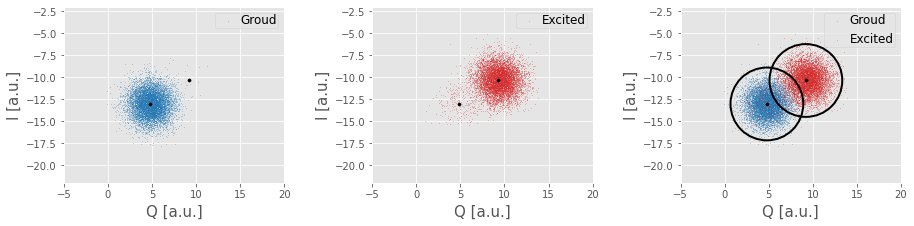

In [364]:
%matplotlib inline

fig = plt.figure()

fig.set_figheight(15)
fig.set_figwidth(15)

ax1 = fig.add_subplot(1,3,1, aspect=1)
ax2 = fig.add_subplot(1,3,2, aspect=1)
ax3 = fig.add_subplot(1,3,3, aspect=1)



x2 = np.real(mean_gnd) 
y2 = np.imag(mean_gnd) 

x1 = np.real(mean_exc) 
y1 = np.imag(mean_exc) 


r1 = 0.8 * distance(mean_gnd, mean_exc)

circle_gnd_r1 = plt.Circle((np.real(mean_gnd), np.imag(mean_gnd)), r1, color='black', fill=False,  lw=2)
circle_exc_r1 = plt.Circle((np.real(mean_exc), np.imag(mean_exc)), r1, color='black', fill=False,  lw=2)

# ax1.add_patch(circle_gnd_r1)
# ax1.add_patch(circle_exc_r1)
# ax2.add_patch(circle_gnd_r1)
# ax2.add_patch(circle_exc_r1)
ax3.add_patch(circle_gnd_r1)
ax3.add_patch(circle_exc_r1)



ax1.scatter(np.real(gnd_results), np.imag(gnd_results), 
            s=0.1, cmap='viridis', c='tab:blue', alpha=0.5, label='Groud')

ax2.scatter(np.real(exc_results), np.imag(exc_results), 
            s=0.1, cmap='viriscale_factordis', c='tab:red', alpha=0.5, label='Excited')

ax3.scatter(np.real(gnd_results), np.imag(gnd_results), 
            s=0.1, cmap='viridis', c='tab:blue', alpha=0.5, label='Groud')

ax3.scatter(np.real(exc_results), np.imag(exc_results), 
            s=0.1, cmap='viriscale_factordis', c='tab:red', alpha=0.5, label='Excited')


# mean point
ax1.scatter(np.real(mean_gnd), np.imag(mean_gnd), s=10, cmap='viridis', c='k', alpha=1.0)
ax1.scatter(np.real(mean_exc), np.imag(mean_exc), s=10, cmap='viridis', c='k', alpha=1.0)
ax2.scatter(np.real(mean_gnd), np.imag(mean_gnd), s=10, cmap='viridis', c='k',alpha=1.0)
ax2.scatter(np.real(mean_exc), np.imag(mean_exc), s=10, cmap='viridis', c='k',alpha=1.0)
ax3.scatter(np.real(mean_gnd), np.imag(mean_gnd), s=10, cmap='viridis', c='k',alpha=1.0)
ax3.scatter(np.real(mean_exc), np.imag(mean_exc), s=10, cmap='viridis', c='k',alpha=1.0)



ax1.set_xlim([-5, 20])
ax1.set_ylim([-22, -2])

ax2.set_xlim([-5, 20])
ax2.set_ylim([-22, -2])

ax3.set_xlim([-5, 20])
ax3.set_ylim([-22, -2])



ax1.set_ylabel('I [a.u.]', fontsize=15)
ax1.set_xlabel('Q [a.u.]', fontsize=15)
ax2.set_ylabel('I [a.u.]', fontsize=15)
ax2.set_xlabel('Q [a.u.]', fontsize=15)
ax3.set_ylabel('I [a.u.]', fontsize=15)
ax3.set_xlabel('Q [a.u.]', fontsize=15)


ax1.legend(fontsize=12, loc='upper right', borderpad=0.1, handletextpad=0.05)
ax2.legend(fontsize=12, loc='upper right', borderpad=0.1, handletextpad=0.05)
ax3.legend(fontsize=12, loc='upper right', borderpad=0.1, handletextpad=0.05)


plt.subplots_adjust(wspace=0.4)

#plt.savefig('comparing.png', dpi=400, bbox_inches = 'tight')


# Show graphic
plt.show();